## 课程目标：学习softmax分类模型

# 1.1 获取数据集
#### 通过torchvision的torchvision.datasets来下载这个数据集。第一次调用时会自动从网上获取数据

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Desktop/Datasets/FashionMNIST', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Desktop/Datasets/FashionMNIST', train=False, download=False, transform=transforms.ToTensor())


In [3]:
import matplotlib.pyplot as plt

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
    
def show_fashion_mnist(images, labels):
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

## 1.2 展示数据集

In [4]:
print(len(mnist_train), len(mnist_test))
feature,label = mnist_train[0]
print(feature.shape, type(label))

60000 10000
torch.Size([1, 28, 28]) <class 'int'>


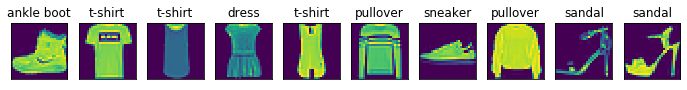

In [5]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 1.3  读取小批量

In [32]:
batch_size = 256
num_workers = 0

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 1.3.1 读取一遍训练数据需要的时间

In [ ]:
import time

start = time.time()

for X,y in train_iter:
    continue

print('%.2f sec' % (time.time() - start))

# 2 手动实现softmax回归

## 2.1 初始化模型参数
### 模型的输入向量的长度是 28×28=784：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为784×10和1×10的矩阵

In [40]:
import numpy as np

num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
print(W.shape, b.shape)
print(W,b)

torch.Size([784, 10]) torch.Size([10])
tensor([[ 0.0089,  0.0019,  0.0073,  ...,  0.0034,  0.0097,  0.0061],
        [ 0.0057, -0.0061, -0.0014,  ..., -0.0057,  0.0175, -0.0152],
        [ 0.0050,  0.0189, -0.0032,  ..., -0.0073, -0.0041,  0.0040],
        ...,
        [-0.0194,  0.0013, -0.0024,  ...,  0.0128, -0.0024,  0.0232],
        [-0.0074, -0.0103, -0.0015,  ...,  0.0105, -0.0002, -0.0208],
        [ 0.0049,  0.0161,  0.0011,  ..., -0.0047,  0.0134, -0.0006]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [41]:
#跟踪梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 2.2 定义模型

In [17]:
print('输入shape : %d' % num_inputs)
print('输出shape : %d' % num_outputs)

# 每行都是合法的概率分布
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

def net_softmax(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

输入shape : 784
输出shape : 10


## 2.3 定义损失函数

In [37]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1,1)))

## 2.4 定义优化函数

In [38]:
def sgd(params, lr, batch_size):
    # 为了和原书保持一致，这里除以了batch_size，但是应该是不用除的，因为一般用PyTorch计算loss时就默认已经
    # 沿batch维求了平均了。
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 2.4 计算分类准确率


In [34]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [35]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [42]:
print(evaluate_accuracy(test_iter, net_softmax))

0.1128


## 2.5 训练模型

In [33]:
num_epochs, lr =2, 0.1

def train_softmax(net, train_iter, test_iter, loss, num_epochs, batch_size,
                  params=None, lr=None, optimizer=None):
    
    for epoch in range(num_epochs):
        
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            #梯度清0
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
                
            l.backward()
            
            if optimizer is not None:
                optimizer.step()
            else:
                sgd(params, lr, batch_size)
            
            train_l_sum += l.item()
            
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            
            n += y.shape[0]
            
            test_acc = evaluate_accuracy(test_iter, net)
            
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
            

In [ ]:
train_softmax(net_softmax, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
             [W,b], lr)

In [ ]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net_softmax(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

In [ ]:
show_fashion_mnist(X[0:9], titles[0:9])

# 3 pytorch简洁实现

## 3.1读取数据

In [7]:
batch_size = 256
num_workers=0

mnist_train = torchvision.datasets.FashionMNIST(root='~/Desktop/Datasets/FashionMNIST', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Desktop/Datasets/FashionMNIST', train=False, download=False, transform=transforms.ToTensor())

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
X,y = iter(train_iter).next()
print(X.shape)
print(type(y))

torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'>


## 3.2 定义和初始化模型

#### softmax回归的输出层是一个全连接层，所以我们用一个线性模块就可以了。因为前面我们数据返回的每个batch样本x的形状为(batch_size, 1, 28, 28), 所以我们要先用view()将x的形状转换成(batch_size, 784)才送入全连接层

### 3.2.1 模型实现1

In [ ]:
from torch import nn
from torch.nn import init

num_inputs = 784
num_outputs = 10

class LinearNet_Test1(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet_Test1, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y

LinearNet_test1 = LinearNet_Test1(num_inputs, num_outputs)   
    
init.normal_(LinearNet_test1.linear.weight, mean=0, std=0.01)
init.constant_(LinearNet_test1.linear.bias, val=0)

### 3.2.2 模型实现2

In [11]:
from torch import nn
from torch.nn import init

num_inputs = 784
num_outputs = 10

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1) 
    
from collections import OrderedDict


LinearNet_test2 = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

init.normal_(LinearNet_test2.linear.weight, mean=0, std=0.01)
init.constant_(LinearNet_test2.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3.7.3 交叉熵损失函数

In [24]:
loss = nn.CrossEntropyLoss()

## 3.7.4 定义优化算法

In [25]:
net = LinearNet_test2

optimizer = torch.optim.SGD(net.parameters(), lr=100)

In [26]:
import math
print(math.exp(100))

2.6881171418161356e+43


## 3.7.5训练模型

In [43]:
num_epochs = 2

train_softmax(net, train_iter, test_iter, loss, num_epochs, batch_size,
             optimizer = optimizer)

epoch 1, loss 1.3681, train acc 0.684, test acc 0.771
epoch 2, loss 0.7657, train acc 0.758, test acc 0.627
